In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

np.set_printoptions(precision=6, suppress=True)
delta_rel = np.array([0.001, 0.001, 0.0005, 0.001])

### Исходные данные

In [14]:
def f(x1, x2, x3, x4):
    return x1/x2**2 + x2/x3**2 + x4/x1**2

datasets = [
    # Набор 1
    {
        "x": np.array([1.0, 2.0, 3.0, 4.0]),
        "delta_rel": delta_rel,
        "name": "Набор 1"
    },
    # Набор 2
    {
        "x": np.array([2.0, 1.5, 2.5, 3.5]),
        "delta_rel": delta_rel,
        "name": "Набор 2"
    },
    # Набор 3
    {
        "x": np.array([1.2, 2.2, 3.1, 3.9]),
        "delta_rel": delta_rel,
        "name": "Набор 3"
    }
]

### Метод Монте-Карло

In [15]:
def calc_monte_carlo(x_val, delta_abs, N=100000):
    xj_mc = np.array([
        np.random.uniform(x_val[i] - delta_abs[i], x_val[i] + delta_abs[i], N) 
        for i in range(len(x_val))
    ])
    y0 = f(*x_val)
    yj_mc = f(*xj_mc)
    dy_mc = np.abs(yj_mc - y0)
    return np.max(dy_mc)

### Метод Крейновича

In [16]:
def calc_kreinovich(x_val, delta_abs, N=300, k=0.01):
    d_i = k * delta_abs
    y0 = f(*x_val)
    
    xj = np.array([
        np.random.standard_cauchy(size=N) * d_i[i] + x_val[i] 
        for i in range(len(x_val))
    ])
    
    yj = f(*xj)
    dy = yj - y0
    
    def F(d, dy_arr):
        return np.sum(d ** 2 / (dy_arr ** 2 + d ** 2)) - len(dy_arr) / 2
    
    d_hat_sol = fsolve(F, 0.001, args=(dy,))
    return np.abs(d_hat_sol[0]) / k

### Метод линеаризации с комплексным приращением

In [17]:
def calc_complex_step(x_val, delta_abs):
    step = 1e-20
    n = len(x_val)
    derivatives = []
    
    for i in range(n):
        x_c = x_val.astype(complex)
        x_c[i] += 1j * step
        val = f(*x_c)
        deriv = val.imag / step
        derivatives.append(deriv)
    
    derivatives = np.array(derivatives)
    delta_y = np.sum(np.abs(derivatives) * delta_abs)
    return delta_y, derivatives

### Расчеты


Набор 1: x = [1. 2. 3. 4.]
y0 = f(x) = 4.472222


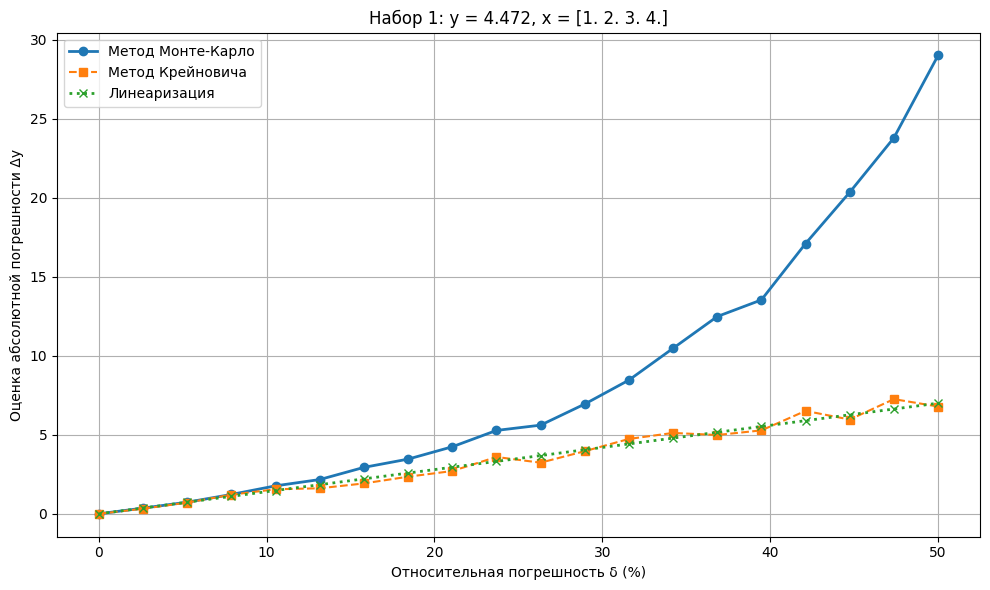


Последние 5 значений для Набор 1:
δ (%)      Δy (MC)         Δy (Kr)         Δy (Лин)       
39.48      13.533619       5.279412        5.526611       
42.11      17.097944       6.512527        5.894958       
44.74      20.342349       5.965452        6.263305       
47.37      23.787415       7.256516        6.631653       
50.00      28.997473       6.788529        7.000000       

Набор 2: x = [2.  1.5 2.5 3.5]
y0 = f(x) = 2.003889


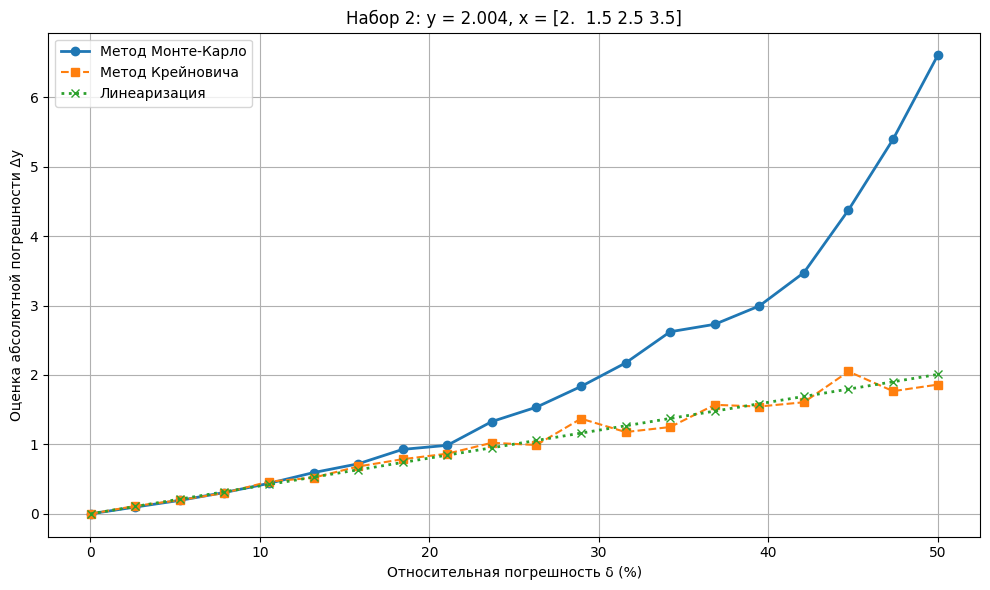


Последние 5 значений для Набор 2:
δ (%)      Δy (MC)         Δy (Kr)         Δy (Лин)       
39.48      2.994622        1.546008        1.585298       
42.11      3.474274        1.607291        1.690957       
44.74      4.376501        2.050344        1.796617       
47.37      5.394990        1.767101        1.902277       
50.00      6.602541        1.861256        2.007937       

Набор 3: x = [1.2 2.2 3.1 3.9]
y0 = f(x) = 3.185195


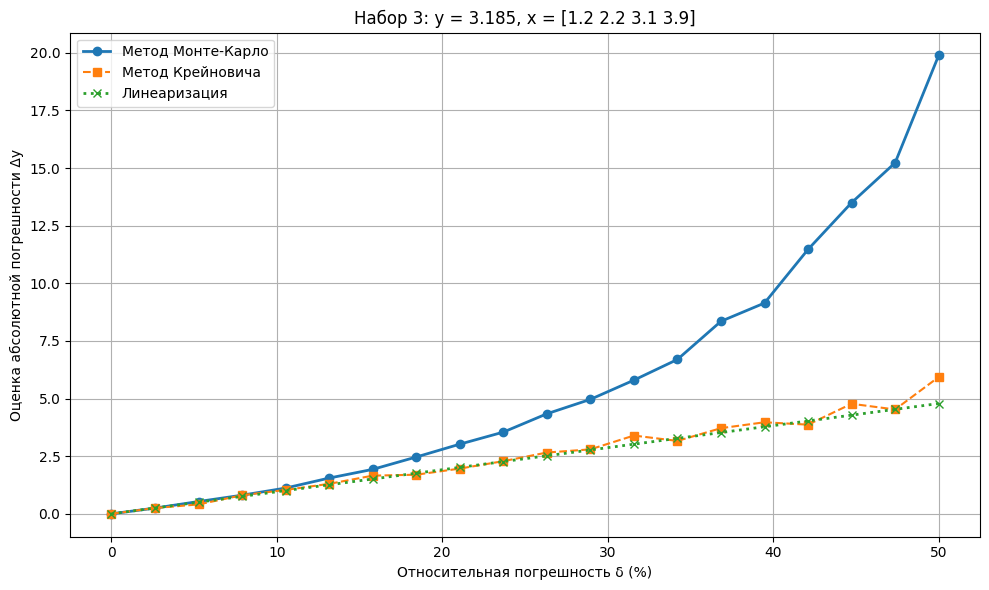


Последние 5 значений для Набор 3:
δ (%)      Δy (MC)         Δy (Kr)         Δy (Лин)       
39.48      9.144848        3.972316        3.777465       
42.11      11.470896       3.868398        4.029232       
44.74      13.498220       4.774403        4.280999       
47.37      15.229051       4.527225        4.532766       
50.00      19.885078       5.933642        4.784534       


In [18]:
# Диапазон изменения погрешности (от 0.01% до 50%)
delta_range = np.linspace(0.0001, 0.5, 20)

# Для каждого набора данных
for dataset_idx, dataset in enumerate(datasets):
    print(f"\n{dataset['name']}: x = {dataset['x']}")
    print(f"y0 = f(x) = {f(*dataset['x']):.6f}")
    
    # Результаты для этого набора
    res_mc = []
    res_kr = []
    res_lin = []
    
    for d_rel in delta_range:
        # Изменяем все погрешности одинаково
        current_delta_rel = dataset['delta_rel'].copy() * d_rel / dataset['delta_rel'].mean()
        current_delta_abs = current_delta_rel * dataset['x']
        
        # Метод Монте-Карло
        val_mc = calc_monte_carlo(dataset['x'], current_delta_abs, N=1000)
        res_mc.append(val_mc)
        
        # Метод Крейновича
        val_kr = calc_kreinovich(dataset['x'], current_delta_abs, N=300)
        res_kr.append(val_kr)
        
        # Метод линеаризации
        val_lin, _ = calc_complex_step(dataset['x'], current_delta_abs)
        res_lin.append(val_lin)
    
    # Построение графика для этого набора
    plt.figure(figsize=(10, 6))
    plt.plot(delta_range*100, res_mc, 'o-', label='Метод Монте-Карло', linewidth=2)
    plt.plot(delta_range*100, res_kr, 's--', label='Метод Крейновича', linewidth=1.5)
    plt.plot(delta_range*100, res_lin, 'x:', label='Линеаризация', linewidth=2)
    
    plt.title(f'{dataset["name"]}: y = {f(*dataset["x"]):.3f}, x = {dataset["x"]}')
    plt.xlabel('Относительная погрешность δ (%)')
    plt.ylabel('Оценка абсолютной погрешности Δy')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Вывод таблицы для последних 5 значений
    print(f"\nПоследние 5 значений для {dataset['name']}:")
    print(f"{'δ (%)':<10} {'Δy (MC)':<15} {'Δy (Kr)':<15} {'Δy (Лин)':<15}")
    for i in range(-5, 0):
        idx = len(delta_range) + i
        print(f"{delta_range[idx]*100:<10.2f} {res_mc[idx]:<15.6f} {res_kr[idx]:<15.6f} {res_lin[idx]:<15.6f}")